In [25]:
import pandas as pd
import numpy as np
import env
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

# import splitting and imputing functions
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

# turn off pink boxes for demo
import warnings
warnings.filterwarnings("ignore")

def get_db_url(database):
    from env import host, user, password
    url = f'mysql+pymysql://{user}:{password}@{host}/{database}'
    return url

def get_data_from_sql():
    query = """
    SELECT customer_id, monthly_charges, tenure, total_charges
    FROM customers
    WHERE contract_type_id = 3;
    """
    df = pd.read_sql(query, get_db_url('telco_churn'))
    return df

def wrangle_telco():
    """
    Queries the telco_churn database
    Returns a clean df with four columns:
    customer_id(object), monthly_charges(float), tenure(int), total_charges(float)
    """
    customers = get_data_from_sql()
    #customers = pd.read_sql("SELECT customer_id, monthly_charges, tenure, total_charges FROM customers WHERE contract_type_id = 3", env.get_db_url('telco_churn'))
    customers['total_charges'] = customers['total_charges'].str.strip()
    customers = customers.replace(r'^\s*$', np.nan, regex=True)
    customers = customers.dropna()
    customers['total_charges'] = customers['total_charges'].astype(float)
    return customers

def split_data(df):
    '''
    take in a DataFrame and return train, validate, and test DataFrames; stratify on survived.
    return train, validate, test DataFrames.
    '''
    train_validate, test = train_test_split(df, test_size=.2, random_state=123)
    train, validate = train_test_split(train_validate, 
                                       test_size=.3, 
                                       random_state=123)
    return train, validate, test

In [4]:
customers_df = wrangle_telco()

In [14]:
train, validate, test = split_data(customers_df)

In [16]:
train.info(), validate.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 943 entries, 361 to 1399
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      943 non-null    object 
 1   monthly_charges  943 non-null    float64
 2   tenure           943 non-null    int64  
 3   total_charges    943 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 36.8+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 405 entries, 1474 to 353
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      405 non-null    object 
 1   monthly_charges  405 non-null    float64
 2   tenure           405 non-null    int64  
 3   total_charges    405 non-null    float64
dtypes: float64(2), int64(1), object(1)
memory usage: 15.8+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 337 entries, 305 to 1321
Data columns (total 4 columns):
 

(None, None, None)

In [17]:
train.head()

,customer_id,monthly_charges,tenure,total_charges
361,2208-NKVVH,24.25,43,1077.95
1174,6993-YGFJV,112.55,69,7806.50
1100,6614-FHDBO,109.20,72,7878.30
579,3512-IZIKN,65.30,70,4759.75
1431,8414-OOEEL,79.50,66,5196.10


#### Hypothesize: Form and document your initial hypotheses about how the predictors (independent variables, features, or attributes) interact with the target (y-value or dependent variable).

#### Document your initial hypotheses. Write them down so they're concrete and not in your head.

Hypothesis: The longer a customer has been with Telco the greater their total charges will be.

In [27]:
#you can make a new 'scaled' column in original dataframe if you wish
train['monthly_charges_scaled']  = scaled  

In [28]:
train.head()

,customer_id,monthly_charges,tenure,total_charges,monthly_charges_scaled
361,2208-NKVVH,24.25,43,1077.95,0.058296
1174,6993-YGFJV,112.55,69,7806.50,0.938216
1100,6614-FHDBO,109.20,72,7878.30,0.904833
579,3512-IZIKN,65.30,70,4759.75,0.467364
1431,8414-OOEEL,79.50,66,5196.10,0.608869


In [46]:
train.drop(['monthly_charges_scaled'], axis=1, inplace=True)

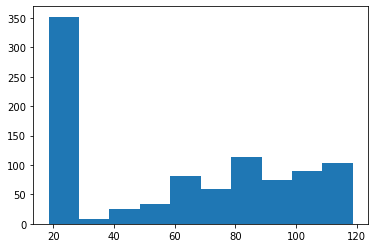

In [29]:
# plot distribution of monthly charges
plt.hist(train.monthly_charges);

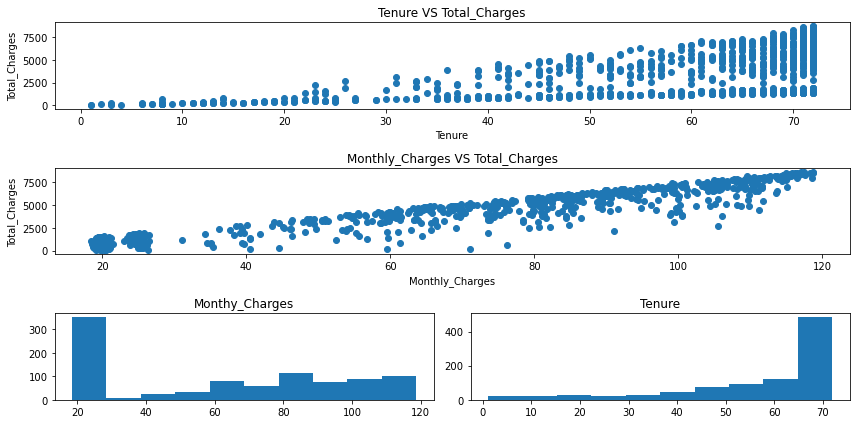

In [36]:
# plot all three charts above in a single figure
fig = plt.figure(figsize = (12,6))

gs = plt.GridSpec(3,2)

ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, :])
ax3 = fig.add_subplot(gs[2,0])
ax4 = fig.add_subplot(gs[2,1])

ax1.scatter(train.tenure, train['total_charges'])
ax1.set(xlabel = 'Tenure', ylabel = 'Total_Charges', title = 'Tenure VS Total_Charges')

ax2.scatter(train.monthly_charges, train['total_charges'])
ax2.set(xlabel = 'Monthly_Charges', ylabel = 'Total_Charges', title = 'Monthly_Charges VS Total_Charges')

ax3.hist(train.monthly_charges)
ax3.set(title = 'Monthy_Charges')

ax4.hist(train.tenure)
ax4.set(title = 'Tenure')
plt.tight_layout();

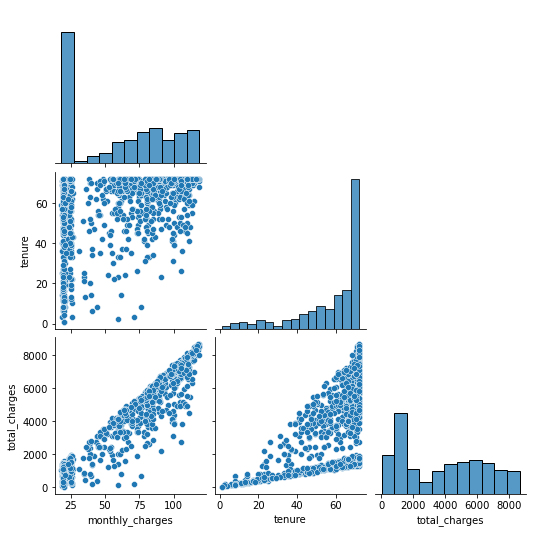

In [47]:
sns.pairplot(train, corner=True)

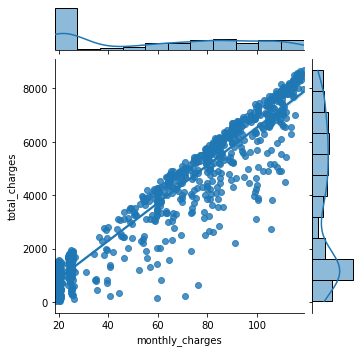

In [48]:
sns.jointplot(x="monthly_charges", y="total_charges", data=train,  kind='reg', height=5)
plt.show()

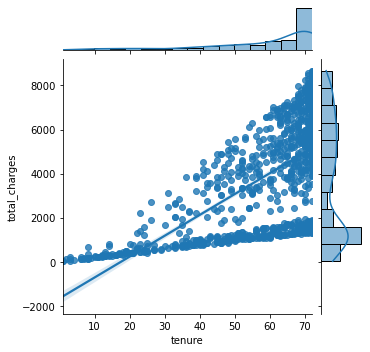

In [49]:
sns.jointplot(x="tenure", y="total_charges", data=train,  kind='reg', height=5)
plt.show()

In [50]:
# Since my variables are not normally distributed, I might choose Spearman instead.

tenure_spearman = train.corr(method='spearman')
tenure_spearman

,monthly_charges,tenure,total_charges
monthly_charges,1.000000,0.464369,0.925764
tenure,0.464369,1.000000,0.712780
total_charges,0.925764,0.712780,1.000000


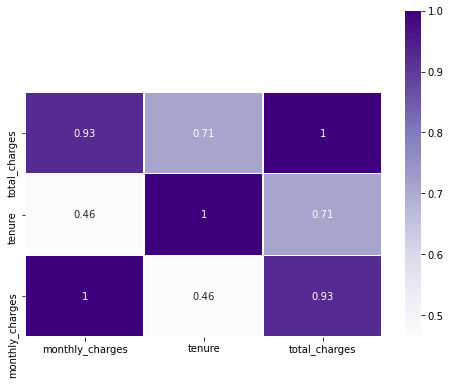

In [51]:
plt.figure(figsize=(8,6))
sns.heatmap(tenure_spearman, cmap='Purples', annot=True, linewidth=0.5)
plt.ylim(0, 4)

plt.show()

In [53]:
# Use a scipy stats function spearmanr to calculate the correlation coefficient and the p-value.

r, p_value = spearmanr(train.tenure, train.total_charges)
print(f'Correlation Coefficient: {r}\nP-value: {p_value}')

Correlation Coefficient: 0.7127802289600237
P-value: 4.055969001138354e-147


#### Heatmap Takeaways

* Monthly charges and total charges have a very high correlation coefficient.
* Tenure and total charges also seem to have a positive correlation.
* Tenure and monthly charges don't seem to be positively correlated.

### 2. Write a function named plot_variable_pairs that accepts a dataframe as input and plots all of the pairwise relationships along with the regression line for each pair.

In [76]:
def plot_variable_pairs(dataframe):
    return sns.pairplot(dataframe, corner=True)

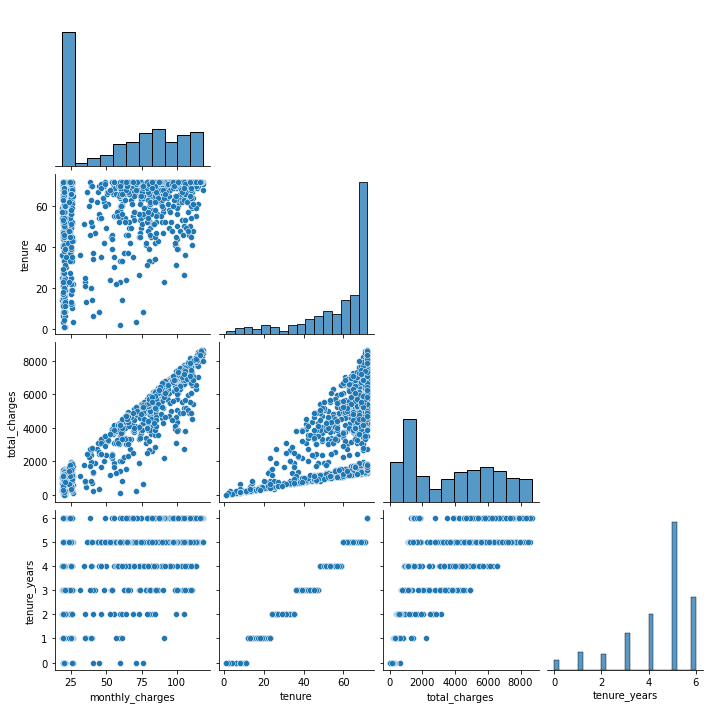

In [79]:
plot_variable_pairs(train)

### 3. Write a function named months_to_years that accepts your telco churn dataframe and returns a dataframe with a new feature tenure_years, in complete years as a customer.

In [68]:
def months_to_years(dataframe):
    train['tenure_years'] = (train['tenure']/12).apply(np.floor)

### 4. Write a function named plot_categorical_and_continuous_vars that accepts your dataframe and the name of the columns that hold the continuous and categorical features and outputs 3 different plots for visualizing a categorical variable and a continuous variable.

In [69]:
train.head()

,customer_id,monthly_charges,tenure,total_charges,tenure_years
361,2208-NKVVH,24.25,43,1077.95,3.0
1174,6993-YGFJV,112.55,69,7806.50,5.0
1100,6614-FHDBO,109.20,72,7878.30,6.0
579,3512-IZIKN,65.30,70,4759.75,5.0
1431,8414-OOEEL,79.50,66,5196.10,5.0


In [74]:
continuous_variables = ['monthly_charges','tenure','total_charges','tenure_years']